# MultiSWAG

## Introduction

In this notebook we demonstrate how to train `PusH` with MultiSWAG (Multiple Stochastic Weight Averaging Gaussian) on a sine wave:
$$
\begin{align}
    y & = sin(x) + \epsilon \\
    \epsilon & \sim \mathcal{N}(0, 0.05) \,.
\end{align}
$$
SWAG is a method of **Bayesian deep learning** that forms a distribution of parameter states by averaging over training steps. It first trains a Neural Network for a set number of `pretrain_epochs` then calculates the mean and square mean of the parameters trained over `swag_epochs`. SWAG performs **Bayesian inference** by using the mean and square mean to sample `num_sample` parameter states. Prediction results are averaged over `num_sample` parameter states. Thus it can be said that SWAG performs averaging within its basin of attraction. SWAG can be extended to MultiSWAG, similar to a deep ensemble, which allows for averaging over multiple basins of attraction.

## Dataset

In [1]:
import math
from bdl import SineWithNoiseDataset

D = 1                                  # dimensions
N = 2048                               # number of points
train_begin_radians = -2 * math.pi     # left interval
train_end_radians = 2 * math.pi        # right interval

# Define the dataset as a PyTorch dataset
dataset = SineWithNoiseDataset(N, D, train_begin_radians, train_end_radians)

### Plotting the Dataset 

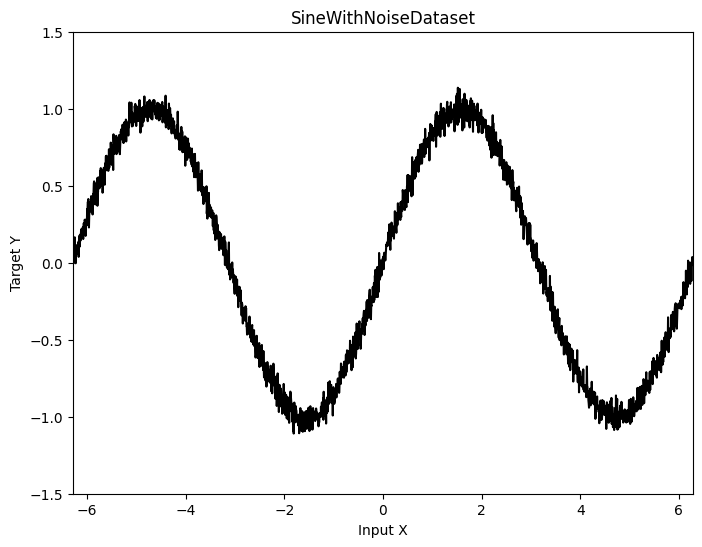

In [2]:
import matplotlib.pyplot as plt

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.plot(dataset.xs, dataset.ys, c ='black')
plt.title('SineWithNoiseDataset')
plt.xlabel('Input X')
plt.ylabel('Target Y')
plt.xlim(train_begin_radians, train_end_radians)
plt.ylim(-1.5, 1.5)
plt.show()

### Defining our model

In [3]:
from bdl import MiniNN, BiggerNN

Each `MiniNN` contains two fully-connected layers of dimension $D$ and uses a ReLU activation function. The code is contained in the module `bdl`.
```py
class MiniNN(nn.Module):
    def __init__(self, D):
        super(MiniNN, self).__init__()
        self.fc1 = nn.Linear(D, D)
        self.fc2 = nn.Linear(D, D)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.nn.ReLU()(x)
        x = self.fc2(x)
        return x 
```

A `BiggerNN` is built out of $n$ `MiniNN` NN blocks so we can vary the size of the network to explore how the number of layers affects our results. 
```py
class BiggerNN(nn.Module):
    def __init__(self, n, input_dim, output_dim, hidden_dim):
        super(BiggerNN, self).__init__()
        self.minis = []
        self.n = n
       
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        for i in range(0, n):
            self.minis += [MiniNN(hidden_dim)]
            self.add_module("mini_layer"+str(i), self.minis[-1])
        self.fc = nn.Linear(hidden_dim, output_dim)
            
    def forward(self, x):
        x = self.input_layer(x)
        for i in range(0, self.n):
            x = self.minis[i](x)
        return self.fc(x)
```

## Training MultiSWAG in Push

To run MSWAG we will be using the `bayes.ensemble.train_mswag` function. This function requires the following to run.


1. A **dataloader** (`torch.utils.data`)
2. A **loss** function i.e. (`torch.nn.MSELoss`)
3. The number of **pretrain_epochs** (`int`)
4. The number of **swag_epochs** (`int`)
5. A **model** class (`torch.nn.Module`)
6. The model class's initialization parameters (`*args`)
7. The number of **devices** (GPUs) to use (`int`)
8. The number of SWAG **models** to generate (`int`)

and returns the `MultiSWAG` object. The `MultiSWAG` object can perform inference with its member function `posterior_pred`

```py
def train_mswag(dataloader: DataLoader, loss_fn: Callable, pretrain_epochs: int,
                swag_epochs: int, nn: Callable, *args, num_devices=1, cache_size: int = 4, view_size: int = 4,
                num_models: int, mswag_entry=_mswag_particle, mswag_state={}, f_save=False,
                mswag_sample_entry=_mswag_sample_entry, mswag_sample=_mswag_sample):
    mswag = MultiSWAG(nn, *args, num_devices=num_devices, cache_size=cache_size, view_size=view_size)
    mswag.bayes_infer(dataloader, loss_fn, num_models, pretrain_epochs=pretrain_epochs,
                      swag_epochs=swag_epochs, mswag_entry=mswag_entry, mswag_state=mswag_state,
                      f_save=f_save, mswag_sample_entry=mswag_sample_entry, mswag_sample=mswag_sample)
    return mswag
```

In [4]:
import torch
import push.bayes.swag
from torch.utils.data import DataLoader



# 1. Create dataloader
batch_size = 512
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 2. Model hyperparameters
n = 4
input_dim = 1
output_dim = 1
hidden_dim = 64

# 3. Training parameters
swag_epochs = 250
pretrain_epochs = 750
loss_fn = torch.nn.MSELoss()

two_particle_mswag = push.bayes.swag.train_mswag(
    dataloader,
    loss_fn,
    pretrain_epochs,
    swag_epochs,
    BiggerNN, n, input_dim, output_dim, hidden_dim,
    num_devices = 2,
    num_models = 2,
    mswag_state = {}
)

100%|██████████| 250/250 [00:17<00:00, 14.62it/s]


#### Training more particles with MultiSWAG 

In [5]:
four_particle_mswag = push.bayes.swag.train_mswag(
    dataloader,
    loss_fn,
    pretrain_epochs,
    swag_epochs,
    BiggerNN, n, input_dim, output_dim, hidden_dim,
    num_devices = 2,
    num_models = 4,
    mswag_state = {}
)

eight_particle_mswag = push.bayes.swag.train_mswag(
    dataloader,
    loss_fn,
    pretrain_epochs,
    swag_epochs,
    BiggerNN, n, input_dim, output_dim, hidden_dim,
    num_devices = 2,
    num_models = 8,
    mswag_state = {}
)

  0%|          | 0/750 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:49<00:00,  5.04it/s]


## Test Data
We set up the test dataset now with the sine wave of $D = 1$ dimensions defined on the interval $(-8\pi, 8\pi)$ with $N = 2048$ data points.

In [6]:
import numpy as np
test_begin_radians = -8 * math.pi
test_end_radians = 8 * math.pi
oos_dataset = SineWithNoiseDataset(N, D, test_begin_radians, test_end_radians)
test_dataloader = DataLoader(oos_dataset, batch_size=64, shuffle=False)
oos_xs = oos_dataset.xs
oos_ys = oos_dataset.ys

# Extract the data
xs = dataset.xs
ys = dataset.ys

# Flatten our x values for out of sample
x_flat = xs.view(-1).numpy()
oos_x_flat = oos_xs.view(-1).numpy()

## Performing Inference
The `MultiSwag` class implements the `posterior_pred` function which can compute the mean, median, min, and max predictions over our `PusH` distribution's particles. Inference is handled on the particle level, with each particle performing inference concurrently. With our `MultiSwag` objects obtained from training we will pass in our test dataloader to the `posterior_pred` and specify the `mode`(s) of prediction we would like (mean, median, min, max, and/or std), we indicate whether this is a regression task with `f_reg`.

`posterior_pred` returns a `dict` containing prediction results, with the selected `mode` values as keys.

In [11]:
two_particle_outputs = two_particle_mswag.posterior_pred(test_dataloader, loss_fn, num_samples=20, mode=["mean","median","min","max","std"], f_reg=True)
four_particle_outputs = four_particle_mswag.posterior_pred(test_dataloader, loss_fn, num_samples=20, mode=["mean","median","min","max","std"], f_reg=True)
eight_particle_outputs = eight_particle_mswag.posterior_pred(test_dataloader, loss_fn, num_samples=20, mode=["mean","median","min","max","std"], f_reg=True)

### Plotting our Results

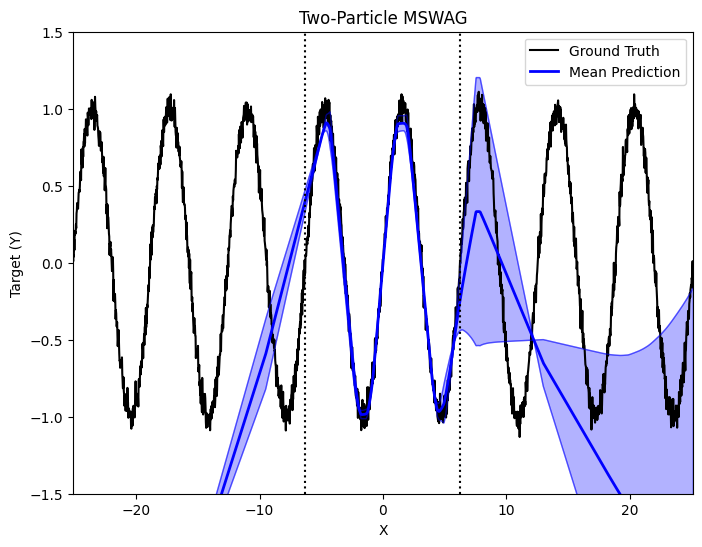

In [12]:
plt.figure(figsize=(8, 6))
pred_upper = two_particle_outputs["mean"] + two_particle_outputs["std"]
pred_lower = two_particle_outputs["mean"] - two_particle_outputs["std"]
plt.plot(oos_xs, oos_ys, c="black", label="Ground Truth")
plt.plot(oos_xs, two_particle_outputs["mean"], color="blue", lw=2, label="Mean Prediction")
plt.plot(oos_xs, pred_upper, "-b", alpha=0.5, lw=1)
plt.plot(oos_xs, pred_lower, "-b", alpha=0.5, lw=1)
plt.fill_between(oos_x_flat, pred_lower.flatten(), pred_upper.flatten(), color='blue', alpha=0.3)
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlim(test_begin_radians, test_end_radians)

plt.ylim(-1.5, 1.5)
plt.title('Two-Particle MSWAG')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()


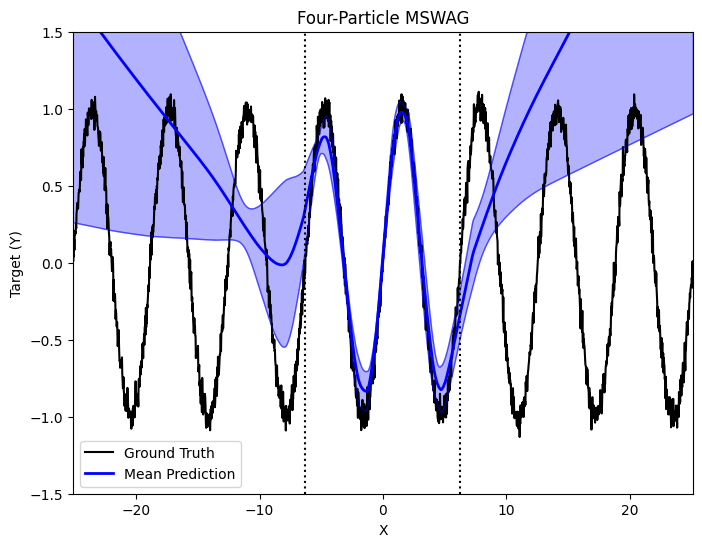

In [13]:
plt.figure(figsize=(8, 6))
pred_upper = four_particle_outputs["mean"] + four_particle_outputs["std"]
pred_lower = four_particle_outputs["mean"] - four_particle_outputs["std"]
plt.plot(oos_xs, oos_ys, c="black", label="Ground Truth")
plt.plot(oos_xs, four_particle_outputs["mean"], color="blue", lw=2, label="Mean Prediction")
plt.plot(oos_xs, pred_upper, "-b", alpha=0.5, lw=1)
plt.plot(oos_xs, pred_lower, "-b", alpha=0.5, lw=1)
plt.fill_between(oos_x_flat, pred_lower.flatten(), pred_upper.flatten(), color='blue', alpha=0.3)
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlim(test_begin_radians, test_end_radians)
plt.ylim(-1.5, 1.5)
plt.title('Four-Particle MSWAG')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()


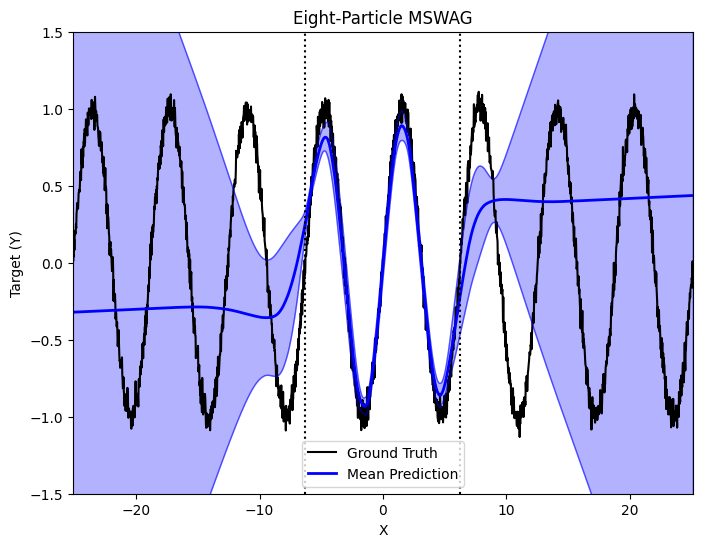

In [14]:
plt.figure(figsize=(8, 6))
pred_upper = eight_particle_outputs["mean"] + eight_particle_outputs["std"]
pred_lower = eight_particle_outputs["mean"] - eight_particle_outputs["std"]
plt.plot(oos_xs, oos_ys, c="black", label="Ground Truth")
plt.plot(oos_xs, eight_particle_outputs["mean"], color="blue", lw=2, label="Mean Prediction")
plt.plot(oos_xs, pred_upper, "-b", alpha=0.5, lw=1)
plt.plot(oos_xs, pred_lower, "-b", alpha=0.5, lw=1)
plt.fill_between(oos_x_flat, pred_lower.flatten(), pred_upper.flatten(), color='blue', alpha=0.3)
plt.axvline(x=train_begin_radians, color="black", linestyle="dotted")
plt.axvline(x=train_end_radians, color="black", linestyle="dotted")
plt.xlim(test_begin_radians, test_end_radians)
plt.ylim(-1.5, 1.5)
plt.title('Eight-Particle MSWAG')
plt.xlabel('X')
plt.ylabel('Target (Y)')
plt.legend()
plt.show()
